In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
import joblib
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from IPython.display import display

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

sns.set_style(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Load Data & Melihat Kembali Potensi Noise pada Dataset

In [78]:
df = pd.read_csv('for_modelling.csv')
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,0.0,credit_card,AZ,27.65,0.0,1985-01-01,1.0,1000.0,1000.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,1000.0,1,0.0,0.0,81539.0,22800.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,1.0,car,GA,1.00,0.0,1999-04-01,5.0,1000.0,1000.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,1000.0,1,0.0,0.0,81539.0,22800.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,0.0,small_business,IL,8.72,0.0,2001-11-01,2.0,1000.0,1000.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,1000.0,1,0.0,0.0,81539.0,22800.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,0.0,other,CA,20.00,0.0,1996-02-01,1.0,35.0,1000.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,1000.0,1,0.0,0.0,81539.0,22800.0
4,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,Source Verified,2011-12-01,0.0,wedding,AZ,11.20,0.0,2004-11-01,3.0,1000.0,1000.0,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,161.03,0.0,1000.0,1,0.0,0.0,81539.0,22800.0


In [79]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237666 entries, 0 to 237665
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           237666 non-null  int64  
 1   member_id                    237666 non-null  int64  
 2   loan_amnt                    237666 non-null  int64  
 3   funded_amnt                  237666 non-null  int64  
 4   funded_amnt_inv              237666 non-null  float64
 5   term                         237666 non-null  object 
 6   int_rate                     237666 non-null  float64
 7   installment                  237666 non-null  float64
 8   grade                        237666 non-null  object 
 9   sub_grade                    237666 non-null  object 
 10  emp_length                   237666 non-null  object 
 11  home_ownership               237666 non-null  object 
 12  annual_inc                   237666 non-null  float64
 13 

In [80]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,2.376660e+05,2.376660e+05,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,2.376660e+05,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,2.376660e+05,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.0,237666.000000,2.376660e+05,2.376660e+05,2.376660e+05
mean,8.539466e+06,9.655219e+06,13475.522161,13429.875329,13301.471688,13.845191,416.659414,7.192637e+04,0.214440,16.429532,0.247297,0.906869,574.844374,888.159253,10.854047,0.134567,1.522467e+04,54.972492,24.807402,328.438167,328.328462,13401.399794,13269.764886,11108.680177,2124.382704,0.921612,167.415306,17.573438,5686.878572,0.005857,830.184052,1.0,0.002886,1.446052e+02,1.211692e+05,2.734967e+04
std,9.261408e+06,1.005104e+07,8061.208716,8036.458023,8073.971005,4.378781,243.623623,5.516243e+04,0.410434,7.694436,0.733771,1.173854,479.328693,301.723653,4.825149,0.420952,1.920881e+04,24.669567,11.663237,2186.965084,2186.325498,9397.228880,9408.837985,8162.582231,2153.994977,6.264300,764.484406,119.060329,6854.789285,0.082862,365.745998,0.0,0.058452,1.882504e+04,1.298382e+05,2.440223e+04
min,5.473400e+04,7.069400e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.375396e+06,1.612891e+06,7200.000000,7200.000000,7125.000000,10.990000,239.180000,4.500000e+04,0.000000,10.710000,0.000000,0.000000,37.000000,1000.000000,7.000000,0.000000,5.912000e+03,37.200000,16.000000,0.000000,0.000000,6295.244820,6170.900000,4930.277500,744.035000,0.000000,0.000000,0.000000,419.730000,0.000000,1000.000000,1.0,0.000000,0.000000e+00,3.973825e+04,1.640000e+04
50%,5.425676e+06,6.447056e+06,12000.000000,12000.000000,11900.000000,13.670000,365.030000,6.142350e+04,0.000000,16.130000,0.000000,1.000000,1000.000000,1000.000000,10.000000,0.000000,1.098900e+04,56.700000,23.000000,0.000000,0.000000,11250.317355,11139.830000,9750.000000,1462.755000,0.000000,0.000000,0.000000,2974.195000,0.000000,1000.000000,1.0,0.000000,0.000000e+00,8.153900e+04,2.280000e+04
75%,1.245706e+07,1.442963e+07,18000.000000,18000.000000,18000.000000,16.590000,545.377500,8.600000e+04,0.000000,21.870000,0.000000,1.000000,1000.000000,1000.000000,13.000000,0.000000,1.906875e+04,74.400000,32.000000,0.000000,0.000000,18188.910000,18042.152500,15250.000000,2696.737500,0.000000,0.000000,0.000000,8853.097500,0.000000,1000.000000,1.0,0.000000,0.000000e+00,1.569152e+05,2.942800e+04
max,3.785416e+07,4.061688e+07,35000.000000,35000.000000,35000.000000,26.060000,1408.130000,7.141778e+06,1.000000,39.990000,29.000000,33.000000,1000.000000,1000.000000,76.000000,11.000000,1.746716e+06,892.300000,150.000000,32160.380000,32160.380000,57777.579870,57777.580000,35000.030000,22777.580000,358.680000,33520.270000,7002.190000,36234.440000,6.000000,1000.000000,1.0,5.000000,9.152545e+06,8.000078e+06,2.013133e+06


#### Distribusi & Outlier data numerik

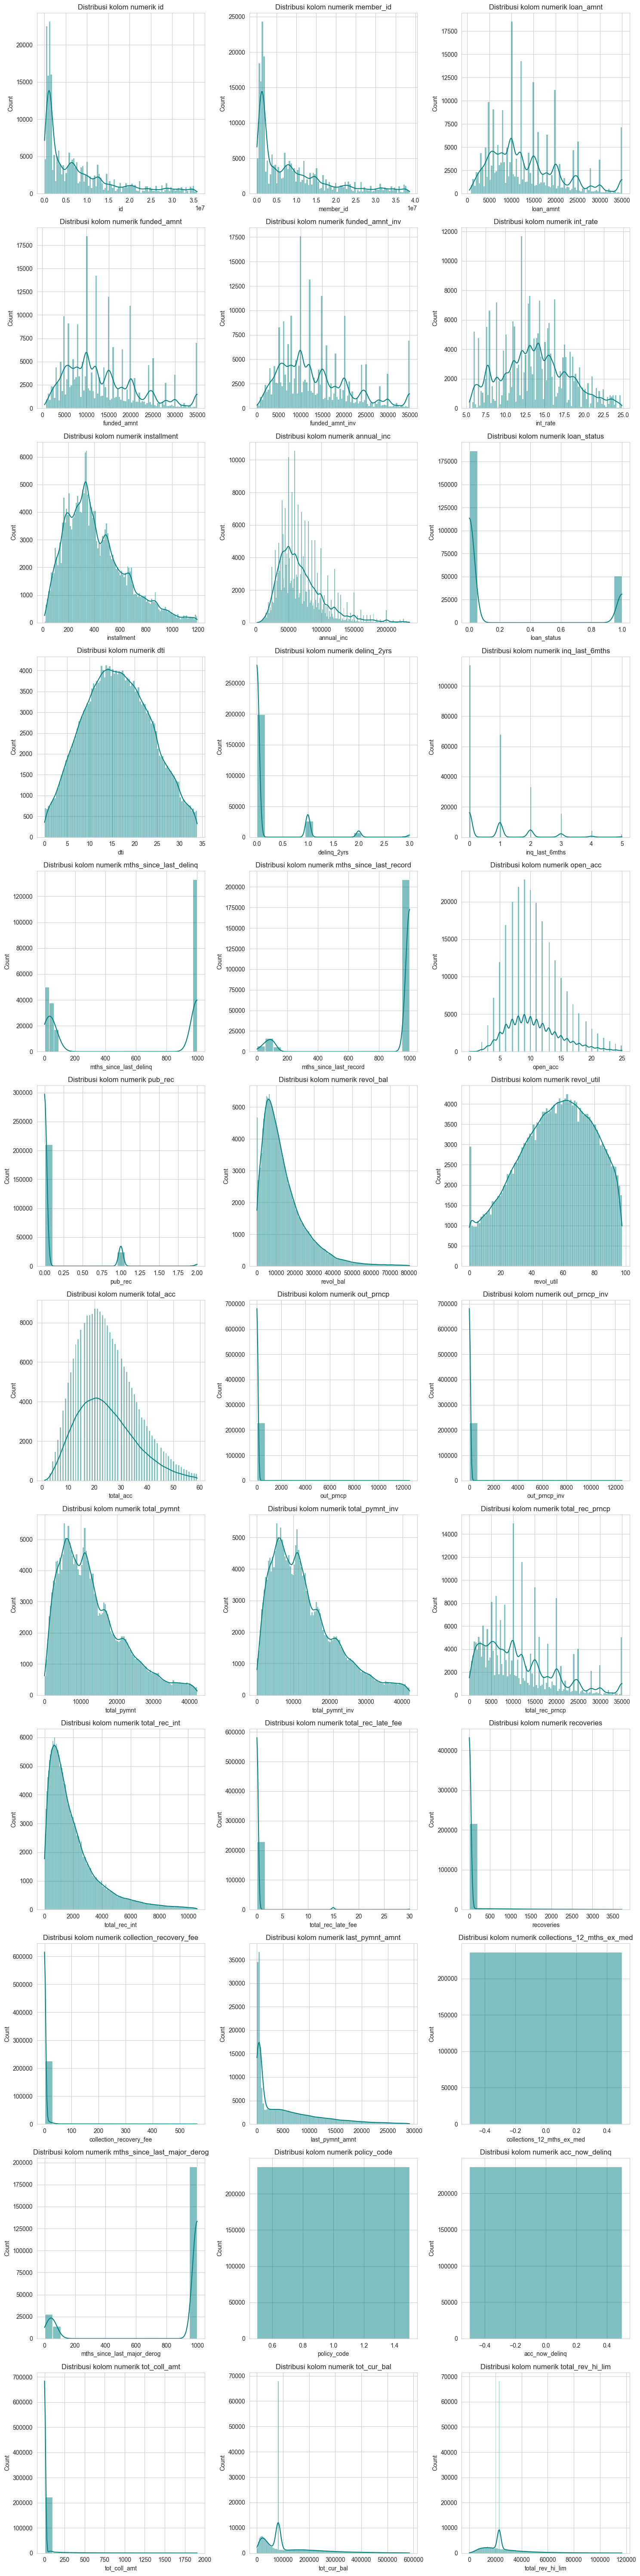

In [81]:
num_features = df.select_dtypes(include=[np.number]).columns.tolist()

n_cols = 3
n_rows = (len(num_features) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))

for i, col in enumerate(num_features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    limit = df[col].quantile(0.99)
    sns.histplot(df[df[col] <= limit][col], kde=True, ax=ax, color='teal')
    ax.set_title(f'Distribusi kolom numerik {col}')
    ax.set_xlabel(f'{col}')

plt.tight_layout()
plt.show()

Outlier pada data

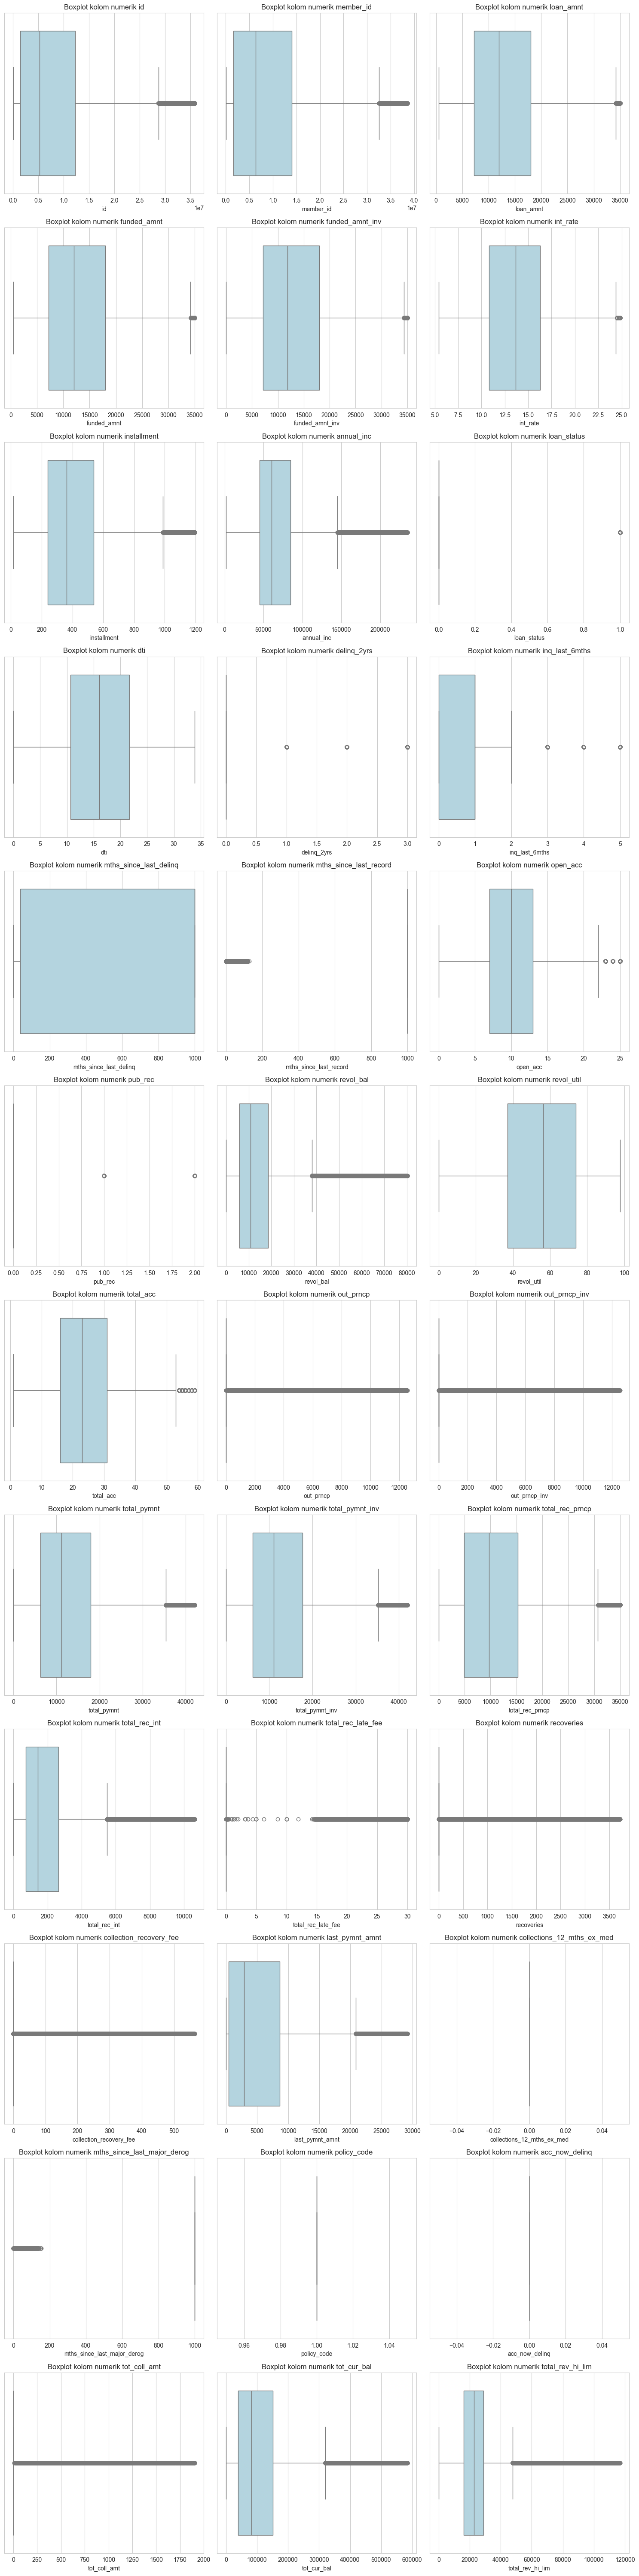

In [82]:
plt.figure(figsize=(15, 5 * n_rows))

for i, col in enumerate(num_features):
    plt.subplot(n_rows, n_cols, i + 1)
    limit = df[col].quantile(0.99)
    sns.boxplot(x=df[df[col] <= limit][col], color='lightblue')
    plt.title(f'Boxplot kolom numerik {col}')
    plt.xlabel(f'{col}')

plt.tight_layout()
plt.show()

Dari hasil visualisasi distribusi dan boxplot, ada beberapa hal yang bisa dilakukan untuk memastikan noise data diminimalkan:
- Kolom numerik collections_12_mths_ex_med, policy_code, acc_now_delinq, id, member_id akan dihapus dikarenakan ada kolom-kolom hanya sebagai unique identifier (tidak berpengaruh ke proses pemodelan prediksi) dan bentuk distribusinya adalah 'Uniform'
- Kolom annual_inc, revol_bal, tot_cur_bal, total_rev_hi_lim, installment, open_acc, revol_util, total_acc, total_pymnt, total_pymnt_inv, total_rec_int, last_pymnt_amnt cenderung skewed sehingga akan diterapkan log transformation
- Kolom lainnya akan ditransformasi dengan metode standardisasi saja
- Sedangkan untuk eksekusi penghapusan nilai outlier tidak akan dilakukan apa-apa dikarenakan kita mencoba untuk mempertahankan setiap detail data yang ada

#### Korelasi Antar Fitur

Berdasarkan pada analisis mutlivariat pada notebook sebelumnya, terdapat beberapa penanganan yang akan dilakukan karena memiliki tingkat korelasi yang cukup tinggi:
- Terdapat variable selain korelasinya tinggi, nilainya akan muncul hanya ketika pinjaman telah berjalan (total_pymnt, total_pymnt_inv, total_rec_prncp, last_pymnt_amnt, out_prncp, out_prncp_inv, recoveries, collection_recovery_fee, total_rec_late_fee, funded_amnt_inv, funded_amnt)
- Beberapa variable dengan korelasi tinggi ke variable target tidak akan di drop dikarenakan dapat menjadi penentu utama risiko, relevansi dengan kapasitas bayar, risiko kredit rill sebelum pinjaman, dll.

#### Data Kategorikal

In [83]:
def list_type_data(typedata):
    print(f'Ini adalah kolom dengan tipe data {typedata}:')
    return df.select_dtypes(include=[typedata]).columns.tolist()

In [84]:
list_object = list_type_data('object')

for i in list_object:
    print(f'List kategori pada kolom {i}: ')
    print(df[i].value_counts())
    print('-----------------------------------\n\n')

Ini adalah kolom dengan tipe data object:
List kategori pada kolom term: 
term
36 months    185671
60 months     51995
Name: count, dtype: int64
-----------------------------------


List kategori pada kolom grade: 
grade
B    71980
C    60677
A    39431
D    38430
E    17910
F     7273
G     1965
Name: count, dtype: int64
-----------------------------------


List kategori pada kolom sub_grade: 
sub_grade
B3    17313
B4    16054
C1    13948
B2    13872
B5    13366
C2    13305
C3    11850
B1    11375
C4    11141
A5    11072
C5    10433
A4    10369
D1     9475
D2     8645
D3     7564
D4     6990
A3     6742
D5     5756
A2     5755
A1     5493
E1     4319
E2     4313
E3     3509
E4     3118
E5     2651
F1     2083
F2     1662
F3     1493
F4     1134
F5      901
G1      661
G2      478
G3      330
G4      257
G5      239
Name: count, dtype: int64
-----------------------------------


List kategori pada kolom emp_length: 
emp_length
10+ years    70936
2 years      22245
< 1 year     19868


Kolom-kolom yang akan diproses dengan One-Hot Encoding yaitu:
- term, home_ownership, verification_status, purpose (dengan menggabungkan kategori lainnya yang sedikit ke kategori baru 'other'), 'initial_list_status'

Kolom-kolom yang akan diproses dengan LabelEncoding (ordinal) yaitu:
- grade, emp_length

Kolom-kolom yang dilakukan aksi lainnya:
- sub_grade, issue_d (akan di generate dulu yearnya untuk mendapatkan fitur baru) akan di drop
- earliest_cr_line akan dikonversi ke kolom baru jarak riwayat kredit (issue_d - earliest_cr_line)
- addr_state akan dikonversi menjadi region

### Penanganan Noise-Noise pada Dataset

Drop Kolom 1

In [85]:
cols_to_drop_1 = ['id', 'member_id', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv', 'collection_recovery_fee', 'total_rec_late_fee', 'recoveries', 'funded_amnt_inv', 'funded_amnt', 'sub_grade']

df.drop(columns=cols_to_drop_1, inplace=True)

Penambahan Fitur

In [86]:
df['installment_to_loan'] = df['installment'] / (df['loan_amnt'] + 1)
df['revol_bal_to_inc'] = df['revol_bal'] / (df['annual_inc'] + 1)
df['open_acc_to_total_acc'] = df['open_acc'] / (df['total_acc'] + 1)

Log Transformation & MinMax Scaler

In [87]:
new_num_features = df.select_dtypes(include=[np.number]).columns.tolist()

cols_to_log_transform = ['annual_inc', 'revol_bal', 'tot_cur_bal', 'total_rev_hi_lim', 'installment', 'open_acc', 'revol_util', 'total_acc', 'total_rec_int']

cols_to_scaler = [col for col in new_num_features if col not in cols_to_log_transform and col != 'loan_status']

In [88]:
scaler = MinMaxScaler()
df[cols_to_scaler] = scaler.fit_transform(df[cols_to_scaler])

log_scaler = FunctionTransformer(np.log1p, validate=True)
df[cols_to_log_transform] = log_scaler.transform(df[cols_to_log_transform])

df.describe()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,mths_since_last_major_derog,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,installment_to_loan,revol_bal_to_inc,open_acc_to_total_acc
count,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000,237666.000000
mean,0.376102,0.408197,5.850043,11.039489,0.214440,0.410841,0.008527,0.027481,0.574844,0.888159,2.392050,0.012233,9.138305,3.853276,3.142445,7.200767,0.830184,0.000016,11.214638,9.992387,0.775512,0.032255,0.291112
std,0.233658,0.212150,0.648016,0.520428,0.410434,0.192409,0.025302,0.035571,0.479329,0.301724,0.407588,0.038268,1.297295,0.734862,0.484229,1.066642,0.365746,0.002057,1.089124,0.687128,0.108069,0.027242,0.101245
min,0.000000,0.000000,2.813611,7.548029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.194203,0.269864,5.481389,10.714440,0.000000,0.267817,0.000000,0.000000,0.037000,1.000000,2.079442,0.000000,8.684909,3.642836,2.833213,6.613431,1.000000,0.000000,10.590095,9.705098,0.747525,0.014551,0.214286
50%,0.333333,0.399709,5.902715,11.025564,0.000000,0.403351,0.000000,0.030303,1.000000,1.000000,2.397895,0.000000,9.304741,4.055257,3.178054,7.288760,1.000000,0.000000,11.308849,10.034560,0.803918,0.026535,0.281250
75%,0.507246,0.541182,6.303310,11.362114,0.000000,0.546887,0.000000,0.030303,1.000000,1.000000,2.639057,0.000000,9.855859,4.322807,3.496508,7.900169,1.000000,0.000000,11.963468,10.289736,0.843891,0.043059,0.357143
max,1.000000,1.000000,7.250728,15.781472,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.343805,1.000000,14.373249,6.794922,5.017280,10.033576,1.000000,1.000000,15.894962,14.515203,1.000000,1.000000,1.000000


Pemrosesan Data Kategorikal

In [89]:
cols_to_onehot = ['term', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status']

def list_category(name_cols):
    for i in list_object:
        if i == name_cols:
            print(f'Ini adalah list kategori {i}')
            print(df[i].value_counts())

In [90]:
list_category('purpose')

Ini adalah list kategori purpose
purpose
debt_consolidation    138317
credit_card            47421
home_improvement       13824
other                  13607
major_purchase          5951
small_business          4766
car                     3498
medical                 2706
wedding                 2017
moving                  1892
house                   1533
vacation                1456
educational              422
renewable_energy         256
Name: count, dtype: int64


In [91]:
purpose_to_other = ['car', 'medical', 'wedding', 'moving', 'house', 'vacation', 'educational', 'renewable_energy']

df['purpose'] = df['purpose'].replace(purpose_to_other, 'other')

In [92]:
list_category('purpose')

Ini adalah list kategori purpose
purpose
debt_consolidation    138317
credit_card            47421
other                  27387
home_improvement       13824
major_purchase          5951
small_business          4766
Name: count, dtype: int64


In [93]:
for i in cols_to_onehot:
    one_hot = pd.get_dummies(df[i], prefix=i, dtype=int)
    df = pd.concat([df, one_hot], axis=1)
    df.drop(columns=[i], inplace=True)

In [94]:
list_category('grade')
list_category('emp_length')

Ini adalah list kategori grade
grade
B    71980
C    60677
A    39431
D    38430
E    17910
F     7273
G     1965
Name: count, dtype: int64
Ini adalah list kategori emp_length
emp_length
10+ years    70936
2 years      22245
< 1 year     19868
3 years      19293
5 years      17224
1 year       16003
4 years      15322
6 years      14241
7 years      13402
8 years      11042
0             9156
9 years       8934
Name: count, dtype: int64


In [95]:
label_mapping_grade = {
    'A': 7,
    'B': 6,
    'C': 5,
    'D': 4,
    'E': 3,
    'F': 2,
    'G': 1
}

label_mapping_emp_length = {
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0,
    '0': 0
}

In [96]:
df['grade_encoded'] = df['grade'].map(label_mapping_grade)
df['emp_length_encoded'] = df['emp_length'].map(label_mapping_emp_length)

df.drop(columns=['grade', 'emp_length'], inplace=True)

In [97]:
df['issue_year'] = pd.DatetimeIndex(df['issue_d']).year
df['earliest_cr_line_year'] = pd.DatetimeIndex(df['earliest_cr_line']).year
df['credit_history_length'] = (df['issue_year'] - df['earliest_cr_line_year'])

df.drop(columns=['issue_d', 'earliest_cr_line', 'issue_year', 'earliest_cr_line_year'], inplace=True)

In [98]:
mapping_addr_state = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI'],
    'South': ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV'],
    'West': ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']
}

In [99]:
df['region'] = df['addr_state'].apply(lambda x: next((region for region, states in mapping_addr_state.items() if x in states), 'Other'))

df = pd.get_dummies(df, columns=['region'], dtype=int)

df.drop(columns=['addr_state'], inplace=True)

In [100]:
df.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,mths_since_last_major_derog,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,installment_to_loan,revol_bal_to_inc,open_acc_to_total_acc,term_ 36 months,term_ 60 months,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,purpose_small_business,initial_list_status_f,initial_list_status_w,grade_encoded,emp_length_encoded,credit_history_length,region_Midwest,region_Northeast,region_South,region_West
0,0.130435,0.253391,5.099073,10.085851,0.0,0.691423,0.0,0.030303,1.000,1.0,1.386294,0.0,9.521422,4.439116,2.302585,6.759336,1.0,0.0,11.308849,10.03456,0.797752,0.081764,0.192857,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,6,10,26,0,0,0,1
1,0.057971,0.477229,4.108083,10.308986,1.0,0.025006,0.0,0.151515,1.000,1.0,1.386294,0.0,7.431300,2.341806,1.609438,6.078032,1.0,0.0,11.308849,10.03456,0.572259,0.008085,0.385714,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,5,0,12,0,0,1,0
2,0.055072,0.510659,4.446526,9.413526,0.0,0.218055,0.0,0.060606,1.000,1.0,1.098612,0.0,7.991931,4.600158,2.397895,6.404650,1.0,0.0,11.308849,10.03456,0.864405,0.034689,0.116883,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,5,10,10,1,0,0,0
3,0.275362,0.390988,5.829857,10.803669,0.0,0.500125,0.0,0.030303,0.035,1.0,2.397895,0.0,8.630343,3.091042,3.637586,7.700897,1.0,0.0,11.308849,10.03456,0.833229,0.016360,0.169173,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,5,10,15,0,0,0,1
4,0.130435,0.120155,5.059171,10.491302,0.0,0.280070,0.0,0.090909,1.000,1.0,2.302585,0.0,8.982687,3.377588,2.564949,6.449490,1.0,0.0,11.308849,10.03456,0.764320,0.031804,0.445055,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,7,3,7,0,0,0,1


Normalisasi kembali beberapa kolom tambahan

In [101]:
df[['emp_length_encoded', 'credit_history_length', 'grade_encoded']] = scaler.fit_transform(df[['emp_length_encoded', 'credit_history_length', 'grade_encoded']])

In [103]:
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'loan_status',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'installment_to_loan', 'revol_bal_to_inc',
       'open_acc_to_total_acc', 'term_ 36 months', 'term_ 60 months',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_major_purchase', 'purpose_other',
       'purpose_small_business', 'initial_list_status_f',
       'initial_list_status_w', 'grade_encoded', 'emp_length_encoded',
       'credit_history_length',

In [104]:
df.head(10)

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,mths_since_last_major_derog,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,installment_to_loan,revol_bal_to_inc,open_acc_to_total_acc,term_ 36 months,term_ 60 months,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,purpose_small_business,initial_list_status_f,initial_list_status_w,grade_encoded,emp_length_encoded,credit_history_length,region_Midwest,region_Northeast,region_South,region_West
0,0.130435,0.253391,5.099073,10.085851,0.0,0.691423,0.0,0.030303,1.000,1.0,1.386294,0.0,9.521422,4.439116,2.302585,6.759336,1.0,0.0,11.308849,10.03456,0.797752,0.081764,0.192857,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0.833333,1.0,0.819048,0,0,0,1
1,0.057971,0.477229,4.108083,10.308986,1.0,0.025006,0.0,0.151515,1.000,1.0,1.386294,0.0,7.431300,2.341806,1.609438,6.078032,1.0,0.0,11.308849,10.03456,0.572259,0.008085,0.385714,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0.666667,0.0,0.685714,0,0,1,0
2,0.055072,0.510659,4.446526,9.413526,0.0,0.218055,0.0,0.060606,1.000,1.0,1.098612,0.0,7.991931,4.600158,2.397895,6.404650,1.0,0.0,11.308849,10.03456,0.864405,0.034689,0.116883,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0.666667,1.0,0.666667,1,0,0,0
3,0.275362,0.390988,5.829857,10.803669,0.0,0.500125,0.0,0.030303,0.035,1.0,2.397895,0.0,8.630343,3.091042,3.637586,7.700897,1.0,0.0,11.308849,10.03456,0.833229,0.016360,0.169173,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0.666667,1.0,0.714286,0,0,0,1
4,0.130435,0.120155,5.059171,10.491302,0.0,0.280070,0.0,0.090909,1.000,1.0,2.302585,0.0,8.982687,3.377588,2.564949,6.449490,1.0,0.0,11.308849,10.03456,0.764320,0.031804,0.445055,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1.000000,0.3,0.638095,0,0,0,1
5,0.072464,0.640504,4.704382,10.778977,0.0,0.133783,0.0,0.060606,1.000,1.0,1.609438,0.0,9.014569,4.483003,1.609438,6.844965,1.0,0.0,11.308849,10.03456,0.899400,0.024626,0.514286,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0.333333,0.9,0.609524,0,0,0,1
6,0.147826,0.768411,5.032984,10.596660,1.0,0.138785,0.0,0.060606,1.000,1.0,2.484907,0.0,8.558527,3.514526,2.639057,5.690157,1.0,0.0,11.308849,10.03456,0.657949,0.018728,0.505102,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0.166667,0.4,0.638095,0,0,0,1
7,0.141304,0.352229,4.807703,9.615872,1.0,0.452113,0.0,0.000000,1.000,1.0,1.098612,0.0,9.135617,3.624341,1.386294,6.281182,1.0,0.0,11.308849,10.03456,0.537535,0.088942,0.321429,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0.833333,0.0,0.638095,0,0,1,0
8,0.173913,0.447190,5.039870,11.184435,0.0,0.403101,0.0,0.060606,1.000,1.0,2.708050,0.0,8.302266,3.072693,3.178054,7.072015,1.0,0.0,11.308849,10.03456,0.563955,0.008052,0.375000,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0.666667,0.5,0.695238,0,0,0,1
9,0.333333,0.352229,6.000276,11.225257,0.0,0.269567,0.0,0.000000,1.000,1.0,2.564949,0.0,10.057795,4.220977,3.555348,7.572544,1.0,0.0,11.308849,10.03456,0.823176,0.044739,0.220408,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0.833333,1.0,0.780952,0,0,0,1


### Proses Pemodelan (dengan SMOTE)

In [118]:
smote = SMOTE(random_state=42)
X = df.drop(columns=['loan_status'])
y = df['loan_status']
X_resampled, y_resampled = smote.fit_resample(X, y)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

#### Tanpa Hyperparameter Tuning

In [120]:
def running_models(model_for_train, name_model):
    model = model_for_train
    print(f'Training model: {name_model}')

    return model.fit(X_train, y_train)

In [121]:
log_reg = running_models(LogisticRegression(max_iter=500), 'Logistic Regression')
rf = running_models(RandomForestClassifier(random_state=42), 'Random Forest Classifier')
lgb = running_models(LGBMClassifier(random_state=42), 'LightGBM Classifier')
xgb = running_models(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=6, learning_rate=0.05), 'XGBoost Classifier')

Training model: Logistic Regression
Training model: Random Forest Classifier
Training model: LightGBM Classifier
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 140070, number of negative: 139981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6415
[LightGBM] [Info] Number of data points in the train set: 280051, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500159 -> initscore=0.000636
[LightGBM] [Info] Start training from score 0.000636
Training model: XGBoost Classifier


#### Evaluasi Awal

In [108]:
def evaluate_model_result(models, name_model):
    y_pred = models.predict(X_test)
    name_models = name_model

    print(f"Evaluation Metrics for {name_model}: \n")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_scoring = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1_scoring}\n")

    print(f"Confusion Matrix {name_model}:")
    c_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(7,5))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='viridis')
    plt.title("Confusion Matrix")
    plt.xlabel("Hasil Prediksi")
    plt.ylabel("Nilai Aktual")
    plt.show()

    roc_auc = roc_auc_score(y_test, models.predict_proba(X_test)[:, 1])
    print(f"ROC AUC Score: {roc_auc}\n")

    return accuracy, precision, recall, f1_scoring, c_matrix, roc_auc, name_models

Evaluation Metrics for Logistic Regression: 

Accuracy: 0.6932759156302557
Precision: 0.7048952641165755
Recall: 0.663914563273359
F1-Score: 0.6837914545394308

Confusion Matrix Logistic Regression:


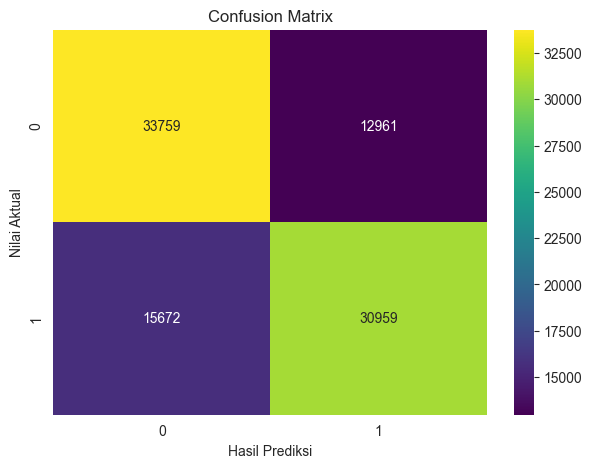

ROC AUC Score: 0.7702013148515465



In [122]:
evaluate_log_reg = evaluate_model_result(log_reg, 'Logistic Regression')

Evaluation Metrics for Random Forest Classifier: 

Accuracy: 0.869438999046609
Precision: 0.9118104211004567
Recall: 0.8177178271965002
F1-Score: 0.8622046353872245

Confusion Matrix Random Forest Classifier:


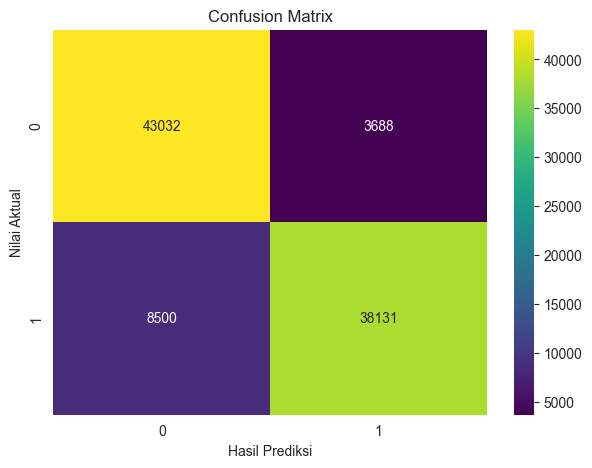

ROC AUC Score: 0.9379616828937214



In [123]:
evaluate_rf = evaluate_model_result(rf, 'Random Forest Classifier')

Evaluation Metrics for Extreme Gradient Boosting Classifier: 

Accuracy: 0.8433546507268267
Precision: 0.927594314417014
Recall: 0.7445261735755184
F1-Score: 0.8260388536623087

Confusion Matrix Extreme Gradient Boosting Classifier:


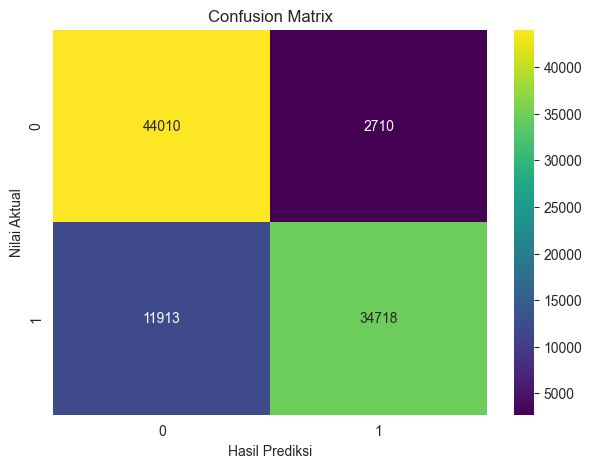

ROC AUC Score: 0.9144626452180085



In [124]:
evaluate_xgb = evaluate_model_result(xgb, 'Extreme Gradient Boosting Classifier')

Evaluation Metrics for LightGBM Classifier: 

Accuracy: 0.8636543797066983
Precision: 0.9573698837115182
Recall: 0.7609315691278334
F1-Score: 0.847922192749779

Confusion Matrix LightGBM Classifier:


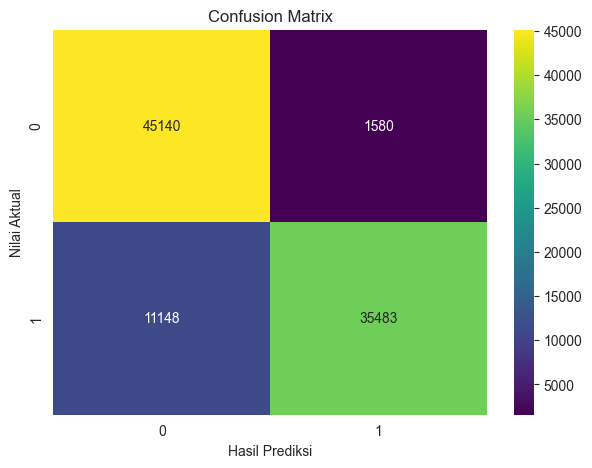

ROC AUC Score: 0.929061783576714



In [125]:
evaluate_lgb = evaluate_model_result(lgb, 'LightGBM Classifier')

In [126]:
list_eval = [evaluate_log_reg, evaluate_rf, evaluate_xgb, evaluate_lgb]

for i in list_eval:
    print(f'Nilai ROC-AUC dari model {i[6]}: {i[5]}')

Nilai ROC-AUC dari model Logistic Regression: 0.7702013148515465
Nilai ROC-AUC dari model Random Forest Classifier: 0.9379616828937214
Nilai ROC-AUC dari model Extreme Gradient Boosting Classifier: 0.9144626452180085
Nilai ROC-AUC dari model LightGBM Classifier: 0.929061783576714


#### Percobaan Hyperparameter Tuning

##### Metode Stack + Random Search Parameter

In [136]:
estimators = [
    ('log_reg', LogisticRegression(max_iter=500, class_weight='balanced')),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500, class_weight='balanced'),
    passthrough=True,
    n_jobs=-1
)

stack_pipeline = ImbPipeline(
    steps=[
        ('model', stack_clf)
    ]
)

param_dist_stack = {
    'model__rf__n_estimators': [100, 200],
    'model__rf__max_depth': [None, 10, 20],
    'model__final_estimator__C': [0.1, 1.0, 10.0]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_stack = RandomizedSearchCV(
    estimator=stack_pipeline,
    param_distributions=param_dist_stack,
    n_iter=5,
    scoring='roc_auc',
    n_jobs=-1,
    cv=skf,
    verbose=2,
    random_state=42
)

In [137]:
random_search_stack.fit(X_train, y_train)

print(f'Best AUC CV: {random_search_stack.best_score_}')
print(f'Best Parameters: {random_search_stack.best_params_}')

best_stack_model = random_search_stack.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best AUC CV: 0.938959929130726
Best Parameters: {'model__rf__n_estimators': 200, 'model__rf__max_depth': None, 'model__final_estimator__C': 0.1}


In [139]:
y_pred_proba_stack = best_stack_model.predict_proba(X_test)[:, 1]
auc_test_stack = roc_auc_score(y_test, y_pred_proba_stack)
print(f'ROC-AUC pada data test untuk Stacking Classifier: {auc_test_stack}')

y_pred_stack = (y_pred_proba_stack >= 0.5).astype(int)
print(classification_report(y_test, y_pred_stack))
print(confusion_matrix(y_test, y_pred_stack))

ROC-AUC pada data test untuk Stacking Classifier: 0.9448959646714823
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89     46720
         1.0       0.93      0.83      0.88     46631

    accuracy                           0.88     93351
   macro avg       0.89      0.88      0.88     93351
weighted avg       0.89      0.88      0.88     93351

[[43704  3016]
 [ 7952 38679]]


##### Metode Random Search Parameter Xgboost 

In [127]:
xgb_hype = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

pipeline_xgb = ImbPipeline(steps=[
    ('model', xgb_hype)
])

param_dist_xgb = {
    'model__n_estimators': [100, 200, 400],
    'model__max_depth': [3, 5, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search_xgb = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_dist_xgb,
    n_iter=8,
    scoring='roc_auc',
    n_jobs=-1,
    cv=skf,
    verbose=2,
    random_state=42
)

In [128]:
random_search_xgb.fit(X_train, y_train)

print(f'Best AUC CV: {random_search_xgb.best_score_}')
print(f'Best Parameters: {random_search_xgb.best_params_}')

best_xgb_model = random_search_xgb.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best AUC CV: nan
Best Parameters: {'model__subsample': 0.6, 'model__n_estimators': 400, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.6}


In [129]:
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
auc_test_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f'ROC-AUC pada data test untuk XGBoost: {auc_test_xgb}')

y_pred_xgb = (y_pred_proba_xgb >= 0.5).astype(int)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

ROC-AUC pada data test untuk XGBoost: 0.9241679286084011
              precision    recall  f1-score   support

         0.0       0.79      0.95      0.87     46720
         1.0       0.94      0.75      0.84     46631

    accuracy                           0.85     93351
   macro avg       0.87      0.85      0.85     93351
weighted avg       0.87      0.85      0.85     93351

[[44613  2107]
 [11641 34990]]


#### Metode Random Search Parameter LightGBM

In [130]:
lgb_hype = LGBMClassifier(objective='binary', boosting_type='gbdt', random_state=42, class_weight=None)

pipeline_lgb = ImbPipeline(
    steps=[
        ('model', lgb_hype)
    ]
)

param_dist_lgb = {
    "model__num_leaves": [31, 50, 70],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [-1, 10, 20],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0],
    "model__min_child_samples": [20, 50, 100]
}

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

random_search_lgb = RandomizedSearchCV(
    estimator=pipeline_lgb,
    param_distributions=param_dist_lgb,
    n_iter=6,
    scoring='roc_auc',
    n_jobs=-1,
    cv=skf,
    verbose=2,
    random_state=42
)

In [131]:
random_search_lgb.fit(X_train, y_train)

print(f'Best AUC CV: {random_search_lgb.best_score_}')
print(f'Best Parameters: {random_search_lgb.best_params_}')

best_lgb_model = random_search_lgb.best_estimator_

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 140070, number of negative: 139981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6415
[LightGBM] [Info] Number of data points in the train set: 280051, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500159 -> initscore=0.000636
[LightGBM] [Info] Start training from score 0.000636
Best AUC CV: 0.9312703159446123
Best Parameters: {'model__subsample': 0.8, 'model__num_leaves': 70, 'model__n_estimators': 400, 'model__min_child_samples': 100, 'model__max_depth': -1, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}


In [132]:
y_pred_proba_lgb = best_lgb_model.predict_proba(X_test)[:, 1]
auc_test_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
print(f'ROC-AUC pada data test untuk LightGBM: {auc_test_lgb}')

y_pred_lgb = (y_pred_proba_lgb >= 0.5).astype(int)
print(classification_report(y_test, y_pred_lgb))
print(confusion_matrix(y_test, y_pred_lgb))

ROC-AUC pada data test untuk LightGBM: 0.9339159961199308
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88     46720
         1.0       0.95      0.78      0.86     46631

    accuracy                           0.87     93351
   macro avg       0.88      0.87      0.87     93351
weighted avg       0.88      0.87      0.87     93351

[[44749  1971]
 [10181 36450]]


### Kesimpulan Akhir Proses Pemodelan

In [140]:
summary_data = [
    {
        "Model": "Logistic Regression (Base)",
        "Accuracy": evaluate_log_reg[0],
        "Precision": evaluate_log_reg[1],
        "Recall": evaluate_log_reg[2],
        "F1-Score": evaluate_log_reg[3],
        "ROC-AUC (Test)": evaluate_log_reg[5],
        "ROC-AUC (CV)": None,
        "Best Params": None
    },
    {
        "Model": "Random Forest (Base)",
        "Accuracy": evaluate_rf[0],
        "Precision": evaluate_rf[1],
        "Recall": evaluate_rf[2],
        "F1-Score": evaluate_rf[3],
        "ROC-AUC (Test)": evaluate_rf[5],
        "ROC-AUC (CV)": None,
        "Best Params": None
    },
    {
        "Model": "XGBoost (Base)",
        "Accuracy": evaluate_xgb[0],
        "Precision": evaluate_xgb[1],
        "Recall": evaluate_xgb[2],
        "F1-Score": evaluate_xgb[3],
        "ROC-AUC (Test)": evaluate_xgb[5],
        "ROC-AUC (CV)": None,
        "Best Params": None
    },
    {
        "Model": "LightGBM (Base)",
        "Accuracy": evaluate_lgb[0],
        "Precision": evaluate_lgb[1],
        "Recall": evaluate_lgb[2],
        "F1-Score": evaluate_lgb[3],
        "ROC-AUC (Test)": evaluate_lgb[5],
        "ROC-AUC (CV)": None,
        "Best Params": None
    },
    {
        "Model": "Stacking (RandomSearch)",
        "Accuracy": accuracy_score(y_test, y_pred_stack),
        "Precision": precision_score(y_test, y_pred_stack),
        "Recall": recall_score(y_test, y_pred_stack),
        "F1-Score": f1_score(y_test, y_pred_stack),
        "ROC-AUC (Test)": auc_test_stack,
        "ROC-AUC (CV)": random_search_stack.best_score_,
        "Best Params": random_search_stack.best_params_
    },
    {
        "Model": "XGBoost (RandomSearch)",
        "Accuracy": accuracy_score(y_test, y_pred_xgb),
        "Precision": precision_score(y_test, y_pred_xgb),
        "Recall": recall_score(y_test, y_pred_xgb),
        "F1-Score": f1_score(y_test, y_pred_xgb),
        "ROC-AUC (Test)": auc_test_xgb,
        "ROC-AUC (CV)": random_search_xgb.best_score_,
        "Best Params": random_search_xgb.best_params_
    },
    {
        "Model": "LightGBM (RandomSearch)",
        "Accuracy": accuracy_score(y_test, y_pred_lgb),
        "Precision": precision_score(y_test, y_pred_lgb),
        "Recall": recall_score(y_test, y_pred_lgb),
        "F1-Score": f1_score(y_test, y_pred_lgb),
        "ROC-AUC (Test)": auc_test_lgb,
        "ROC-AUC (CV)": random_search_lgb.best_score_,
        "Best Params": random_search_lgb.best_params_
    }
]

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC (Test),ROC-AUC (CV),Best Params
0,Logistic Regression (Base),0.693276,0.704895,0.663915,0.683791,0.770201,NaN,None
1,Random Forest (Base),0.869439,0.911810,0.817718,0.862205,0.937962,NaN,None
2,XGBoost (Base),0.843355,0.927594,0.744526,0.826039,0.914463,NaN,None
3,LightGBM (Base),0.863654,0.957370,0.760932,0.847922,0.929062,NaN,None
4,Stacking (RandomSearch),0.882508,0.927665,0.829470,0.875824,0.944896,0.93896,"{'model__rf__n_estimators': 200, 'model__rf__m..."
5,XGBoost (RandomSearch),0.852728,0.943203,0.750359,0.835802,0.924168,NaN,"{'model__subsample': 0.6, 'model__n_estimators..."
6,LightGBM (RandomSearch),0.869825,0.948700,0.781669,0.857123,0.933916,0.93127,"{'model__subsample': 0.8, 'model__num_leaves':..."


### Save Model

In [144]:
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(best_lgb_model, 'models/best_lgb_model.pkl')
joblib.dump(best_stack_model, 'models/best_stack_model.pkl')
joblib.dump(best_xgb_model, 'models/best_xgb_model.pkl')
joblib.dump(log_reg, 'models/logistic_regression_model.pkl')
joblib.dump(rf, 'models/random_forest_model.pkl')


['models/random_forest_model.pkl']